In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(123)
%matplotlib inline

# Dataset

Text(0, 0.5, 'Target values')

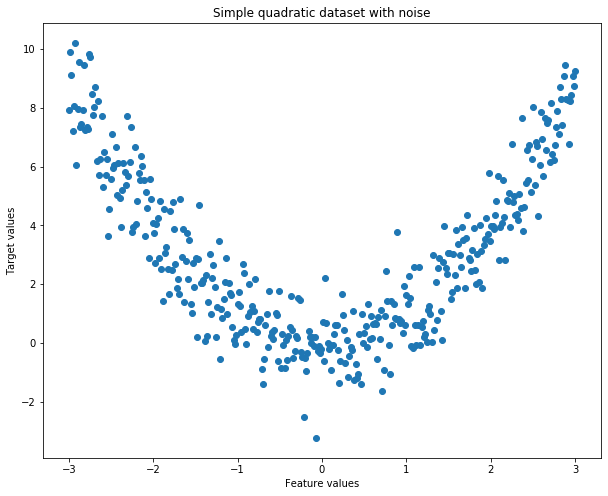

In [2]:
X = np.linspace(-3, 3, 400)
y = X ** 2 + np.random.randn(400)

plt.figure(figsize=(10,8))
plt.scatter(X, y)
plt.title("Simple quadratic dataset with noise")
plt.xlabel("Feature values")
plt.ylabel("Target values")

In [3]:
X = X[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (300, 1)
Shape y_train: (300,)
Shape X_test: (100, 1)
Shape y_test: (100,)


In [4]:
class DecisionTree:
    def __init__(self):
        self.root_dict = None
        self.tree_dict = None
    def split_dataset(self,X,y,feature_idx,threshold):
        left_idx = np.where(X[:,feature_idx]<threshold)
        right_idx = np.where(X[:,feature_idx]>threshold)
        
        left_subset = X[left_idx]
        y_left = y[left_idx]
        
        right_subset = X[right_idx]
        y_right = y[right_idx]
        
        splits = {
            'left': left_subset,
            'y_left':y_left,
            'right':right_subset,
            'y_right':y_right,
        }
        return splits
        
    def mean_squared_error(self,y_left,y_right,n_left,n_right):
        mse_left, mse_right = 0, 0

        if len(y_left) != 0:
            y_hat_left = (1 / n_left) * np.sum(y_left)
            mse_left = (1 / n_left) * np.sum((y_left - y_hat_left) ** 2)

        if len(y_right) != 0:
            y_hat_right = (1 / n_right) * np.sum(y_right)
            mse_right = (1 / n_right) * np.sum((y_right - y_hat_right) ** 2)

        return mse_left, mse_right
    
    def get_cost(self,splits):
        y_left = splits['y_left']
        y_right = splits['y_right']

        n_left = len(y_left)
        n_right = len(y_right)
        n_total = n_left + n_right

        mse_left, mse_right = self.mean_squared_error(y_left, y_right, n_left, n_right)
        cost = (n_left / n_total) * mse_left + (n_right / n_total) * mse_right

        return cost
    
    def find_best_split(self,X,y):
        n_samples, n_features = X.shape
        best_feature_idx, best_threshold, best_cost, best_splits = np.inf, np.inf, np.inf, None

        for feature_idx in range(n_features):
            for i in range(n_samples):
                current_sample = X[i]
                threshold = current_sample[feature_idx]
                splits = self.split_dataset(X, y, feature_idx, threshold)
                cost = self.get_cost(splits)

                if cost < best_cost:
                    best_feature_idx = feature_idx
                    best_threshold = threshold
                    best_cost = cost
                    best_splits = splits

        best_split_params = {
            'feature_idx': best_feature_idx,
            'threshold': best_threshold,
            'cost': best_cost,
            'left': best_splits['left'],
            'y_left': best_splits['y_left'],
            'right': best_splits['right'],
            'y_right': best_splits['y_right'],
        }

        return best_split_params
    
    def build_tree(self,node_dict,depth,max_depth,min_samples):
        left_samples = node_dict['left']
        right_samples = node_dict['right']
        y_left_samples = node_dict['y_left']
        y_right_samples = node_dict['y_right']
        
        if len(y_left_samples) == 0 or len(y_right_samples) == 0:
            node_dict["left_child"] = node_dict["right_child"] = self.create_terminal_node(np.append(y_left_samples, y_right_samples))
            return None
        
        if depth >= max_depth:
            node_dict["left_child"] = self.create_terminal_node(y_left_samples)
            node_dict["right_child"] = self.create_terminal_node(y_right_samples)
            return None
        if len(right_samples) < min_samples:
            node_dict["right_child"] = self.create_terminal_node(y_right_samples)
        else:
            node_dict["right_child"] = self.find_best_split(right_samples, y_right_samples)
            self.build_tree(node_dict["right_child"], depth+1, max_depth, min_samples)

        if len(left_samples) < min_samples:
            node_dict["left_child"] = self.create_terminal_node(y_left_samples)
        else:
            node_dict["left_child"] = self.find_best_split(left_samples, y_left_samples)
            self.build_tree(node_dict["left_child"], depth+1, max_depth, min_samples)
        
        return node_dict
    
    def create_terminal_node(self,y):
        return np.mean(y)
    def train(self,X,y,max_depth,min_samples):
        self.n_classes = len(set(y))
        self.root_dict = self.find_best_split(X, y)
        self.tree_dict = self.build_tree(self.root_dict, 1, max_depth, min_samples)
        
    def predict(self,X,node):
        feature_idx = node['feature_idx']
        threshold = node['threshold']

        if X[feature_idx] < threshold:
            if isinstance(node['left_child'], (float)):  #叶子节点
                return node['left_child']
            else:
                prediction = self.predict(X, node['left_child'])
        elif X[feature_idx] >= threshold:
            if isinstance(node['right_child'], (float)):
                return node['right_child']
            else:
                prediction = self.predict(X, node['right_child'])

        return prediction

In [5]:
tree = DecisionTree()
tree.train(X_train,y_train,max_depth=2,min_samples=2)

In [6]:
def print_tree(node, depth=0):
    if isinstance(node, (float)):
        print(f"{depth * '  '}predicted class: {round(node, 3)}")
    else:
        print(f"{depth * '  '} feature {node['feature_idx']} < {round(node['threshold'], 3)}, "
             f"cost of split: {round(node['cost'], 3)}")
        print_tree(node["left_child"], depth+1)
        print_tree(node["right_child"], depth+1)
print_tree(tree.tree_dict)

 feature 0 < -2.068, cost of split: 5.835
   feature 0 < -2.654, cost of split: 1.125
    predicted class: 8.148
    predicted class: 5.708
   feature 0 < 1.932, cost of split: 2.44
    predicted class: 1.298
    predicted class: 6.105
